In [1]:
from huggingface_hub import notebook_login
notebook_login()

# Imports

In [1]:
import diffusers
import transformers
import sys
import shutil
import time
from diffusers import StableDiffusionPipeline, StableDiffusionInpaintPipeline
import torch
import os
import random
import requests
from io import BytesIO
import numpy as np
import subprocess
from torchvision import models, transforms
import dlib
from PIL import Image, ImageFilter, ImageDraw, ImageEnhance
import cv2
from pathlib import Path
import math
import matplotlib.pyplot as plt

from scipy.ndimage import binary_closing
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load user images

First convert them to jpg, then plot them.

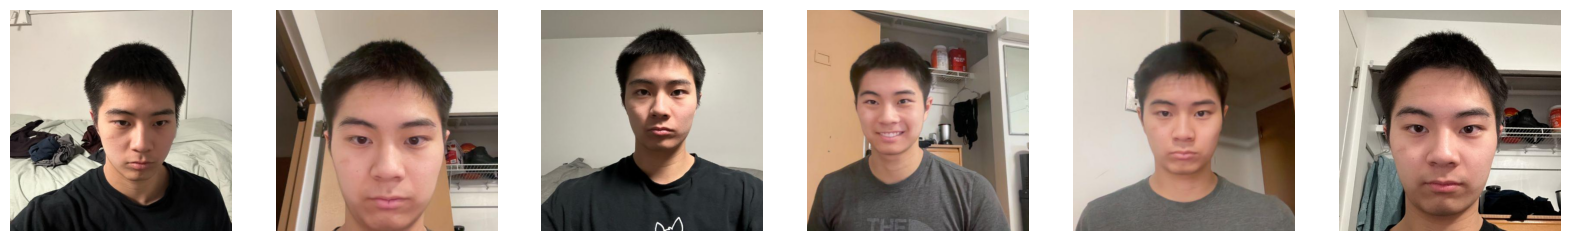

In [2]:
folder_path = 'src/user_images'

image_files = []
for file in os.listdir(folder_path):
    if file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert('RGB')
        
        if not file.lower().endswith('.jpg'):
            jpg_path = os.path.splitext(img_path)[0] + '.jpg'
            img.save(jpg_path, 'JPEG')
            os.remove(img_path)
            image_files.append(jpg_path)
        else:
            image_files.append(img_path)

images_per_row = 6
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
num_images = len(image_files)
num_rows = num_images // images_per_row + (num_images % images_per_row > 0)
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))
fig.subplots_adjust(hspace=0)
if num_rows == 1:
    axes = np.array([axes])
axes = axes.flatten()
for idx, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path).convert('RGB')
    axes[idx].imshow(img)
    axes[idx].axis('off')
for ax in axes[idx + 1:]:
    ax.axis('off')
plt.show()

# Train Base Dreammbooth model on my face

In [3]:
import gc

gc.collect()

torch.cuda.empty_cache()

# Train

In [ ]:
# model_path = "stabilityai/stable-diffusion-2-1"
model_path = "src/models/realisticVisionV60B1_v51VAE"
# model_path = "runwayml/stable-diffusion-v1-5"
dreambooth_filename = "train_dreambooth_person_mask.py"
img_folder_path = "src/user_images" 
output_dir = "ohmw_man_dreambooth"
instance_prompt = "ohmw man"
IMG_SIZE = 512
TRAINING_STEPS = 2000

process = [
    "accelerate", 
    "launch",
    f"{dreambooth_filename}",
    "--train_text_encoder",
    "--allow_tf32",
    f"--pretrained_model_name_or_path={model_path}",
    f"--instance_data_dir={img_folder_path}",
    f"--output_dir={output_dir}",
    f"--instance_prompt='{instance_prompt}'",
    f"--resolution={IMG_SIZE}",
    f"--train_batch_size=1",
    f"--gradient_accumulation_steps=1",
    "--gradient_checkpointing",
    f"--learning_rate=2e-6",
    f"--lr_scheduler=constant",
    f"--lr_warmup_steps=0",
    f"--max_train_steps={TRAINING_STEPS}",
    "--checkpointing_steps=500",


    
    # "--mixed_precision=bf16",
]

process.extend(
    [
        f"--report_to=wandb",
        f'--validation_prompt="photo of ohmw man outdoors, realistic, highly detailed"'
        f"--num_validation_images=3",
        f"--validation_steps=50",
        f"--seed=42",
    ]
)

# Run the process
subprocess.run(process, check=True)

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
04/27/2024 22:23:39 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
wandb: Currently logged in as: austinfujimoriaustinfujimori. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /home/ubuntu/mask_e

In [9]:
model_path = "ohmw_man_dreambooth"

pipe = StableDiffusionPipeline.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

prompt = "chest-up photo of ohmw man"

result = pipe(
    prompt=prompt,
    num_inference_steps=100,
    generator=torch.Generator(device).manual_seed(1),
    width=512,
    height=512,
    strength=1.0
)

image = result.images[0]
image.show()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


KeyboardInterrupt: 

In [15]:
model_path = "ohmw_man_dreambooth"

pipe = StableDiffusionPipeline.from_pretrained(model_path)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

prompt = "photo of ohmw man in new york"

result = pipe(
    prompt=prompt,
    num_inference_steps=50,
    generator=torch.Generator(device).manual_seed(12),
    width=512,
    height=512,
    strength=1.0
)

image = result.images[0]
image.show()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Style image

In [1]:
style_image_path = 'src/style_images/sks style (1).jpg'

Image.open(style_image_path).convert('RGB')

NameError: name 'Image' is not defined

# Train on style

In [7]:
instance_data_dir = "style_images"
class_data_dir = "user_images"
output_dir = "ohmw_man_dreambooth_lora_style_1"
instance_prompt = "shot by sks style"
# instance_prompt = "chest-up photo of ohmw man in sks style"
class_prompt = "a photo of ohmw man"
model_path = "ohmw_man_dreambooth"
lora_filename = "train_dreambooth_lora_style_mask_instance.py"
IMG_SIZE = 512
TRAINING_STEPS = 1500

# instance_data_dir = "style_images"
# class_data_dir = "user_images"
# output_dir = "ohmw_man_dreambooth_full_style"
# instance_prompt = "shot by sks style"
# # instance_prompt = "chest-up photo of ohmw man in sks style"
# class_prompt = "a photo of ohmw man"
# model_path = "ohmw_man_dreambooth"
# lora_filename = "train_dreambooth_style_mask_predicted.py"
# IMG_SIZE = 512
# TRAINING_STEPS = 1500

process = [
    "accelerate",
    "launch",
    f"{lora_filename}",
    "--train_text_encoder",
    "--allow_tf32",
    f"--pretrained_model_name_or_path={model_path}",
    f"--instance_data_dir={instance_data_dir}",
    f"--output_dir={output_dir}",
    f"--instance_prompt='{instance_prompt}'",
    f"--resolution={IMG_SIZE}",
    f"--train_batch_size=1",
    f"--gradient_accumulation_steps=1",
    "--gradient_checkpointing",
    f"--learning_rate=1e-5",
    f"--lr_scheduler=constant",
    f"--lr_warmup_steps=0",
    f"--max_train_steps={TRAINING_STEPS}",
    "--checkpointing_steps=500",
    #"--mixed_precision=bf16",
]

process.extend(
    [
        f"--prior_generation_precision=bf16",
        f"--sample_batch_size=1",
    ]
)

process.extend(
    [
        f"--report_to=wandb",
        f'--validation_prompt="a photo of ohmw man shot by sks style"',
        f"--num_validation_images=3",
        f"--seed=42",
    ]
)

subprocess.run(process, check=True)

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
04/10/2024 14:08:18 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type'} was not found in config. Values will be initialized to default values.
wandb: Currently logged in as: austinfujimoriaustinfujimori. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgr

KeyboardInterrupt: 

wandb: \ 6.464 MB of 6.464 MB uploaded
wandb: Run history:
wandb: loss ▂▁▁▁▄▂▁█▁▃▁▂▃▁▂▂▁▂▂▁▂▂▄▁▁▂▁▆▂▂▁▃▁▁▃▃▂▅▁▂
wandb:   lr ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: loss 0.01276
wandb:   lr 1e-05
wandb: 
wandb: 🚀 View run genial-sea-52 at: https://wandb.ai/austinfujimoriaustinfujimori/dreambooth-lora/runs/3b4lz0r6/workspace
wandb: Synced 5 W&B file(s), 18 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240410_140821-3b4lz0r6/logs


#### Running in command line for debugging

In [ ]:
# import os

# instance_data_dir = "style_images"
# class_data_dir = None
# output_dir = "ohmw_man_dreambooth_lora_style_1"
# instance_prompt = "a photo of ohmw man in sks style"
# class_prompt = None
# model_path = "ohmw_man_dreambooth"
# lora_filename = "train_dreambooth_lora_mask.py"
# IMG_SIZE = 512
# TRAINING_STEPS = 1500

# process = [
#     "accelerate",
#     "launch",
#     f"{lora_filename}",
#     "--train_text_encoder",
#     "--allow_tf32",
#     f"--pretrained_model_name_or_path={model_path}",
#     f"--instance_data_dir={instance_data_dir}",
#     f"--output_dir={output_dir}",
#     f"--instance_prompt='{instance_prompt}'",
#     f"--resolution={IMG_SIZE}",
#     f"--train_batch_size=1",
#     f"--gradient_accumulation_steps=1",
#     "--gradient_checkpointing",
#     f"--learning_rate=1e-6",
#     f"--lr_scheduler=constant",
#     f"--lr_warmup_steps=0",
#     f"--max_train_steps={TRAINING_STEPS}",
#     "--checkpointing_steps=500",
#     #"--mixed_precision=bf16",
#     f"--prior_generation_precision=bf16",
#     f"--sample_batch_size=1",
#     f"--report_to=wandb",
#     f'--validation_prompt="a photo of ohmw man in sks style, realistic, highly detailed"',
#     f"--num_validation_images=3",
#     f"--seed=42",
# ]

# command = " ".join(process)
# # print(f"Running command: {command}")

# os.system(command)

In [ ]:
from diffusers import StableDiffusionPipeline, AutoPipelineForText2Image

model_path = "ohmw_man_dreambooth"
# pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")

pipeline = AutoPipelineForText2Image.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
pipeline.unet.load_attn_procs("ohmw_man_dreambooth_lora_style_1/checkpoint-500", weight_name="pytorch_lora_weights.safetensors")

image = pipeline(
    "photo of ohmwman in sks style",
    num_inference_steps=100, 
    generator=torch.Generator(device).manual_seed(42)
).images[0]

image.show()

# image.save(image1_path)
